In [42]:
# Import the modules
import pandas as pd
from pathlib import Path
from pandas.tseries.offsets import DateOffset
import hvplot.pandas
from sklearn.cluster import KMeans

In [43]:
# Read in the CSV file as a Pandas DataFrame
candle_df = pd.read_csv(
    Path("../Resources/eth.csv")
)

# Review the DataFrame
display(candle_df.head())
display(candle_df.tail())

,time,open,high,low,close,volume
0,2019-09-23 23:59:59.999,209.55,209.55,209.55,209.55,0.01000
1,2019-09-24 23:59:59.999,195.50,195.50,152.56,167.09,2224.36708
2,2019-09-25 23:59:59.999,166.84,174.15,163.18,170.00,181.60286
3,2019-09-26 23:59:59.999,169.95,170.77,153.07,166.69,545.45350
4,2019-09-27 23:59:59.999,166.34,175.54,161.44,173.69,630.91688


,time,open,high,low,close,volume
1161,2022-11-27 23:59:59.999,1205.19,1223.05,1189.13,1193.83,654.26480
1162,2022-11-28 23:59:59.999,1194.92,1198.52,1151.39,1168.13,1260.68583
1163,2022-11-29 23:59:59.999,1167.25,1225.00,1158.51,1216.37,1504.19549
1164,2022-11-30 23:59:59.999,1217.53,1309.49,1212.77,1293.60,2191.94037
1165,2022-12-01 23:59:59.999,1296.18,1298.45,1263.08,1276.50,623.48889


In [44]:
signals_df = candle_df.loc[:,['close','volume']]

signals_df['actual returns'] = signals_df['close'].pct_change()

signals_df = signals_df


display(signals_df.head())
display(signals_df.tail())

,close,volume,actual returns
0,209.55,0.01000,NaN
1,167.09,2224.36708,-0.202625
2,170.00,181.60286,0.017416
3,166.69,545.45350,-0.019471
4,173.69,630.91688,0.041994


,close,volume,actual returns
1161,1193.83,654.26480,-0.009204
1162,1168.13,1260.68583,-0.021527
1163,1216.37,1504.19549,0.041297
1164,1293.60,2191.94037,0.063492
1165,1276.50,623.48889,-0.013219


In [45]:
signals_df.index = (candle_df['time'])
signals_df

,close,volume,actual returns
time,,,
2019-09-23 23:59:59.999,209.55,0.01000,NaN
2019-09-24 23:59:59.999,167.09,2224.36708,-0.202625
2019-09-25 23:59:59.999,170.00,181.60286,0.017416
2019-09-26 23:59:59.999,166.69,545.45350,-0.019471
2019-09-27 23:59:59.999,173.69,630.91688,0.041994
...,...,...,...
2022-11-27 23:59:59.999,1193.83,654.26480,-0.009204
2022-11-28 23:59:59.999,1168.13,1260.68583,-0.021527
2022-11-29 23:59:59.999,1216.37,1504.19549,0.041297


In [46]:
signals_df = signals_df.dropna()

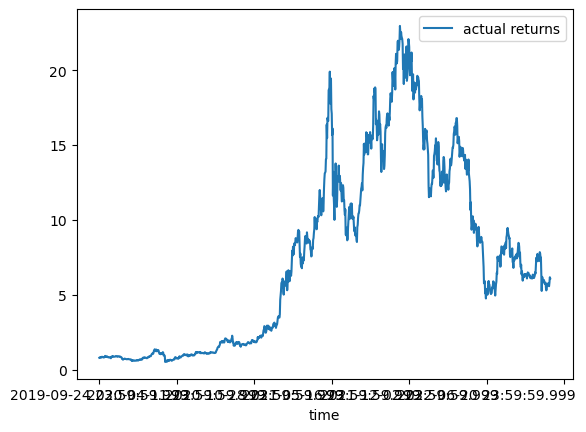

In [47]:
actual_returns = (1 + signals_df[["actual returns"]]).cumprod().plot()

In [48]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

In [49]:
# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the service_ratings DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(signals_df)
    inertia.append(k_model.inertia_)

In [50]:
# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,3.225763e+10
1,2,1.145190e+10
2,3,6.311233e+09
3,4,4.420940e+09
4,5,3.191162e+09


In [51]:
# Plot the DataFrame
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

:Curve   [k]   (inertia)

In [52]:
# Define the model with 4 clusters
model = KMeans(n_clusters=3, random_state=1)

# Fit the model
model.fit(signals_df)

# Make predictions
k_3 = model.predict(signals_df)

# Create a copy of the DataFrame
signals_df_predictions = signals_df.copy()

# Add a class column with the labels
signals_df_predictions['cluster_segment'] = k_3

In [53]:
# Plot the clusters
signals_df_predictions.hvplot.scatter(
    x="close",
    y="volume",
    by="cluster_segment"
)

:NdOverlay   [cluster_segment]
   :Scatter   [close]   (volume)

In [54]:
signals_df.describe()

,close,volume,actual returns
count,1165.000000,1165.000000,1165.000000
mean,1571.279545,4556.943578,0.002892
std,1304.340115,5100.141170,0.051042
min,108.650000,79.553530,-0.441359
25%,259.150000,1300.655520,-0.021185
50%,1356.250000,2702.626210,0.002174
75%,2606.520000,5736.375100,0.028991
max,4809.610000,34393.012140,0.263013


In [55]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

#generate signal to buy stock
signals_df.loc[(signals_df['actual returns'] <= -0.021), 'Signal'] = 1

#generate signal to sell stock
signals_df.loc[(signals_df['actual returns'] >= 0.028), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

/var/folders/l_/rx4r7_q92y90g402xp0kt7m40000gn/T/ipykernel_8769/290437761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df['Signal'] = 0.0


,close,volume,actual returns,Signal
time,,,,
2019-09-24 23:59:59.999,167.09,2224.36708,-0.202625,1.0
2019-09-25 23:59:59.999,170.00,181.60286,0.017416,0.0
2019-09-26 23:59:59.999,166.69,545.45350,-0.019471,0.0
2019-09-27 23:59:59.999,173.69,630.91688,0.041994,-1.0
2019-09-28 23:59:59.999,172.84,158.67273,-0.004894,0.0


,close,volume,actual returns,Signal
time,,,,
2022-11-27 23:59:59.999,1193.83,654.26480,-0.009204,0.0
2022-11-28 23:59:59.999,1168.13,1260.68583,-0.021527,1.0
2022-11-29 23:59:59.999,1216.37,1504.19549,0.041297,-1.0
2022-11-30 23:59:59.999,1293.60,2191.94037,0.063492,-1.0
2022-12-01 23:59:59.999,1276.50,623.48889,-0.013219,0.0


In [56]:
signals_df['Signal'].value_counts()

 0.0    570
-1.0    301
 1.0    294
Name: Signal, dtype: int64

 0.0    570
-1.0    301
 1.0    294
Name: Signal, dtype: int64

In [57]:
signals_df['strategy returns'] = signals_df['actual returns'] * signals_df['Signal'].shift()

display(signals_df.head())
display(signals_df.tail())

/var/folders/l_/rx4r7_q92y90g402xp0kt7m40000gn/T/ipykernel_8769/1354537580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df['strategy returns'] = signals_df['actual returns'] * signals_df['Signal'].shift()


,close,volume,actual returns,Signal,strategy returns
time,,,,,
2019-09-24 23:59:59.999,167.09,2224.36708,-0.202625,1.0,NaN
2019-09-25 23:59:59.999,170.00,181.60286,0.017416,0.0,0.017416
2019-09-26 23:59:59.999,166.69,545.45350,-0.019471,0.0,-0.000000
2019-09-27 23:59:59.999,173.69,630.91688,0.041994,-1.0,0.000000
2019-09-28 23:59:59.999,172.84,158.67273,-0.004894,0.0,0.004894


,close,volume,actual returns,Signal,strategy returns
time,,,,,
2022-11-27 23:59:59.999,1193.83,654.26480,-0.009204,0.0,-0.000000
2022-11-28 23:59:59.999,1168.13,1260.68583,-0.021527,1.0,-0.000000
2022-11-29 23:59:59.999,1216.37,1504.19549,0.041297,-1.0,0.041297
2022-11-30 23:59:59.999,1293.60,2191.94037,0.063492,-1.0,-0.063492
2022-12-01 23:59:59.999,1276.50,623.48889,-0.013219,0.0,0.013219


In [58]:
signals_df = signals_df.dropna()
signals_df

,close,volume,actual returns,Signal,strategy returns
time,,,,,
2019-09-25 23:59:59.999,170.00,181.60286,0.017416,0.0,0.017416
2019-09-26 23:59:59.999,166.69,545.45350,-0.019471,0.0,-0.000000
2019-09-27 23:59:59.999,173.69,630.91688,0.041994,-1.0,0.000000
2019-09-28 23:59:59.999,172.84,158.67273,-0.004894,0.0,0.004894
2019-09-29 23:59:59.999,169.46,1365.66487,-0.019556,0.0,-0.000000
...,...,...,...,...,...
2022-11-27 23:59:59.999,1193.83,654.26480,-0.009204,0.0,-0.000000
2022-11-28 23:59:59.999,1168.13,1260.68583,-0.021527,1.0,-0.000000
2022-11-29 23:59:59.999,1216.37,1504.19549,0.041297,-1.0,0.041297


In [59]:
# Visualize entry position relative to close price
entry = signals_df[signals_df['Signal'] == 1.0]['close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = signals_df[signals_df['Signal'] == -1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[['close']].hvplot(
    line_color='red',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close  * entry * exit

# Show the plot with a title
entry_exit_plot.opts(
    title="ETH , Entry and Exit Points"
)

:Overlay
   .Curve.I          :Curve   [time]   (close)
   .Scatter.Close.I  :Scatter   [time]   (close)
   .Scatter.Close.II :Scatter   [time]   (close)

In [60]:
## Set initial capital
initial_capital = float(200000)

# Set the share size
share_size = 500

In [61]:
# Buy a 500 share position when the Signal equals 1
# Otherwise, `Position` should be -1 (sell)
signals_df['Position'] = share_size * signals_df['Signal']

In [62]:
# Determine the points in time where a 500 share position is bought or sold
signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

In [63]:
# Multiply the close price by the number of shares held, or the Position
signals_df['Portfolio Holdings'] = signals_df['close'] * signals_df['Position']

In [64]:
# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
signals_df['Portfolio Cash'] = initial_capital - (signals_df['close'] * signals_df['Entry/Exit Position']).cumsum() 

In [65]:
# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

In [66]:
# Calculate the portfolio daily returns
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

In [67]:
# Calculate the portfolio cumulative returns
signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

In [68]:
display(signals_df.head())
display(signals_df.tail())

,close,volume,actual returns,Signal,strategy returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
time,,,,,,,,,,,,
2019-09-25 23:59:59.999,170.00,181.60286,0.017416,0.0,0.017416,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2019-09-26 23:59:59.999,166.69,545.45350,-0.019471,0.0,-0.000000,0.0,0.0,0.0,200000.0,200000.0,NaN,NaN
2019-09-27 23:59:59.999,173.69,630.91688,0.041994,-1.0,0.000000,-500.0,-500.0,-86845.0,286845.0,200000.0,0.000000,0.000000
2019-09-28 23:59:59.999,172.84,158.67273,-0.004894,0.0,0.004894,0.0,500.0,0.0,200425.0,200425.0,0.002125,0.002125
2019-09-29 23:59:59.999,169.46,1365.66487,-0.019556,0.0,-0.000000,0.0,0.0,0.0,200425.0,200425.0,0.000000,0.002125


,close,volume,actual returns,Signal,strategy returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
time,,,,,,,,,,,,
2022-11-27 23:59:59.999,1193.83,654.26480,-0.009204,0.0,-0.000000,0.0,0.0,0.0,2678005.0,2678005.0,0.000000,12.390025
2022-11-28 23:59:59.999,1168.13,1260.68583,-0.021527,1.0,-0.000000,500.0,500.0,584065.0,2093940.0,2678005.0,0.000000,12.390025
2022-11-29 23:59:59.999,1216.37,1504.19549,0.041297,-1.0,0.041297,-500.0,-1000.0,-608185.0,3310310.0,2702125.0,0.009007,12.510625
2022-11-30 23:59:59.999,1293.60,2191.94037,0.063492,-1.0,-0.063492,-500.0,0.0,-646800.0,3310310.0,2663510.0,-0.014291,12.317550
2022-12-01 23:59:59.999,1276.50,623.48889,-0.013219,0.0,0.013219,0.0,500.0,0.0,2672060.0,2672060.0,0.003210,12.360300


In [69]:
# Visualize exit position relative to total portfolio value
exit = signals_df[signals_df['Signal'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='yellow',
    marker='v',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = signals_df[signals_df['Signal'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='purple',
    marker='^',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize the value of the total portfolio
total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400
)

# Overlay the plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="ETH Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [time]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [time]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [time]   (Portfolio Total)

In [70]:
## Set Up the Portfolio-Level Risk/Reward Evaluation Metrics

In [71]:
# Create a list for the column name
columns = ["Backtest"]

# Create a list holding the names of the new evaluation metrics
metrics = [
    "Annualized Return",
    "Cumulative Returns",
    "Annual Volatility",
    "Sharpe Ratio",
    "Sortino Ratio"]

# Initialize the DataFrame with index set to the evaluation metrics and the column
eth_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Review the DataFrame
eth_evaluation_df

,Backtest
Annualized Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [72]:
## Calculate the Metrics
import numpy as np

# Calculate annualized return
eth_evaluation_df.loc["Annualized Return"] = (
    signals_df["Portfolio Daily Returns"].mean() * 252
)

# Calculate cumulative return
eth_evaluation_df.loc["Cumulative Returns"] = signals_df["Portfolio Cumulative Returns"][-1]

# Calculate annual volatility
eth_evaluation_df.loc["Annual Volatility"] = (
    signals_df["Portfolio Daily Returns"].std() * np.sqrt(252)
)

# Calculate Sharpe ratio
eth_evaluation_df.loc["Sharpe Ratio"] = (
    signals_df["Portfolio Daily Returns"].mean() * 252) / (
    signals_df["Portfolio Daily Returns"].std() * np.sqrt(252)
)

# Review the result
eth_evaluation_df

,Backtest
Annualized Return,6.842591
Cumulative Returns,12.3603
Annual Volatility,11.669041
Sharpe Ratio,0.586388
Sortino Ratio,NaN


In [73]:
### Sortino Ratio

#### Calculate downside return values

# Create a DataFrame that contains the Portfolio Daily Returns column
sortino_ratio_df = signals_df[["Portfolio Daily Returns"]].copy()

# Create a column to hold downside return values
sortino_ratio_df.loc[:,"Downside Returns"] = 0

# Find Portfolio Daily Returns values less than 0,
# square those values, and add them to the Downside Returns column
sortino_ratio_df.loc[sortino_ratio_df["Portfolio Daily Returns"] < 0,
                     "Downside Returns"] = sortino_ratio_df["Portfolio Daily Returns"]**2

# Review the DataFrame
sortino_ratio_df.tail()

,Portfolio Daily Returns,Downside Returns
time,,
2022-11-27 23:59:59.999,0.000000,0.000000
2022-11-28 23:59:59.999,0.000000,0.000000
2022-11-29 23:59:59.999,0.009007,0.000000
2022-11-30 23:59:59.999,-0.014291,0.000204
2022-12-01 23:59:59.999,0.003210,0.000000


In [74]:
#### Calculate the Sortino ratio

# Calculate the annualized return value
annualized_return = (
    sortino_ratio_df["Portfolio Daily Returns"].mean() * 252
)

# Calculate the annualized downside standard deviation value
downside_standard_deviation = (
    np.sqrt(sortino_ratio_df["Downside Returns"].mean()) * np.sqrt(252)
)

# The Sortino ratio is reached by dividing the annualized return value
# by the downside standard deviation value
sortino_ratio = annualized_return/downside_standard_deviation

# Add the Sortino ratio to the evaluation DataFrame
eth_evaluation_df.loc["Sortino Ratio"] = sortino_ratio

# Review the DataFrame
eth_evaluation_df


,Backtest
Annualized Return,6.842591
Cumulative Returns,12.3603
Annual Volatility,11.669041
Sharpe Ratio,0.586388
Sortino Ratio,8.539741


In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [91]:
# Assign a copy of the `close`, `volume`, 'actual returns' and 'strategy returns' columns to a new DataFrame called `X`
X = signals_df[['close','volume','actual returns','strategy returns']].copy()

# Display sample data
display(X.head())
display(X.tail())

,close,volume,actual returns,strategy returns
time,,,,
2019-09-25 23:59:59.999,170.00,181.60286,0.017416,0.017416
2019-09-26 23:59:59.999,166.69,545.45350,-0.019471,-0.000000
2019-09-27 23:59:59.999,173.69,630.91688,0.041994,0.000000
2019-09-28 23:59:59.999,172.84,158.67273,-0.004894,0.004894
2019-09-29 23:59:59.999,169.46,1365.66487,-0.019556,-0.000000


,close,volume,actual returns,strategy returns
time,,,,
2022-11-27 23:59:59.999,1193.83,654.26480,-0.009204,-0.000000
2022-11-28 23:59:59.999,1168.13,1260.68583,-0.021527,-0.000000
2022-11-29 23:59:59.999,1216.37,1504.19549,0.041297,0.041297
2022-11-30 23:59:59.999,1293.60,2191.94037,0.063492,-0.063492
2022-12-01 23:59:59.999,1276.50,623.48889,-0.013219,0.013219


In [92]:
# Create a target in the `signals_df` called 'y'
y =signals_df['Signal']
y[:5]

time
2019-09-25 23:59:59.999    0.0
2019-09-26 23:59:59.999    0.0
2019-09-27 23:59:59.999   -1.0
2019-09-28 23:59:59.999    0.0
2019-09-29 23:59:59.999    0.0
Name: Signal, dtype: float64

In [114]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2019-09-25 23:59:59.999


In [96]:
# Select the ending period for the training data with an offset of 24 months
training_end = X.loc[:'2021-09-25']

# Display the training end date
training_end.tail()

,close,volume,actual returns,strategy returns
time,,,,
2021-09-20 23:59:59.999,2976.25,28158.48183,-0.105522,-0.105522
2021-09-21 23:59:59.999,2766.36,9907.44258,-0.070522,-0.070522
2021-09-22 23:59:59.999,3078.05,4639.17703,0.112672,0.112672
2021-09-23 23:59:59.999,3154.00,6488.59090,0.024675,-0.024675
2021-09-24 23:59:59.999,2926.01,5141.00830,-0.072286,-0.000000


In [97]:
# Generate the X_train and y_train DataFrames
X_train = training_end
y_train = y.loc[:'2021-09-25']

#X_train.tail()
y_train.tail()

time
2021-09-20 23:59:59.999    1.0
2021-09-21 23:59:59.999    1.0
2021-09-22 23:59:59.999   -1.0
2021-09-23 23:59:59.999    0.0
2021-09-24 23:59:59.999    1.0
Name: Signal, dtype: float64

In [98]:
# Generate the X_test and y_test DataFrames
X_test = X.loc['2021-09-26':]
y_test = y.loc['2021-09-26':]

X_test.tail()
y_test.tail()

time
2022-11-27 23:59:59.999    0.0
2022-11-28 23:59:59.999    1.0
2022-11-29 23:59:59.999   -1.0
2022-11-30 23:59:59.999   -1.0
2022-12-01 23:59:59.999    0.0
Name: Signal, dtype: float64

In [99]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [100]:
# Fit the Standard Scaler with the features 'X' data
X_scaler = scaler.fit(X_train)

In [101]:
# Scale the features 'X' data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [102]:
# Create a Logistic Regression Model 
lr_model = LogisticRegression(solver='lbfgs', random_state=1)

In [103]:
# Train the data
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1)

In [104]:
# Predict outcomes for test data set
lr_pred = lr_model.predict(X_test_scaled)

In [105]:
lr_testing_report = classification_report(y_test, lr_pred)

# Print the classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.98        94
         0.0       0.92      0.99      0.95       219
         1.0       1.00      0.84      0.91       119

    accuracy                           0.95       432
   macro avg       0.96      0.94      0.95       432
weighted avg       0.95      0.95      0.95       432



In [106]:
dtree_model = tree.DecisionTreeClassifier()

In [107]:
# Fitting the model
dtree_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [108]:
# Making predictions using the testing data
dtree_pred = dtree_model.predict(X_test_scaled)

In [109]:
# Displaying classification report
print(classification_report(y_test, dtree_pred))

              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        94
         0.0       1.00      0.99      0.99       219
         1.0       0.99      1.00      1.00       119

    accuracy                           0.99       432
   macro avg       0.99      1.00      0.99       432
weighted avg       0.99      0.99      0.99       432



In [110]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [111]:
# Fit the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [112]:
# Making predictions using the testing data
rf_pred = rf_model.predict(X_test_scaled)

In [113]:
# Displaying classification report
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        94
         0.0       1.00      0.99      0.99       219
         1.0       0.99      1.00      1.00       119

    accuracy                           0.99       432
   macro avg       0.99      1.00      0.99       432
weighted avg       0.99      0.99      0.99       432

